In [1]:
#| label: setup
#| warning: false

import json, re, os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

# Configuration
INPUT_JSON_PATH = "amazon_reduced.json"   # Path to a JSON file containing a *list* of dictionaries
OUTPUT_DIR = "Outputs_amazon"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model Parameters
EMBEDDING_MODEL_NAME = "intfloat/multilingual-e5-small"
MIN_TOPIC_SIZE = 10       # Minimum number of documents to form a topic
N_NEIGHBORS = 12          # Used by UMAP for dimensionality reduction
N_COMPONENTS = 5          # Used by UMAP for dimensionality reduction
RANDOM_STATE = 42         # Ensures reproducible results

In [2]:
#| label: stopwords

def get_english_stopwords():
    """Creates a robust list of English stopwords."""
    try:
        # Start with the standard list from sklearn
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_sw
        base = set(sklearn_sw)
    except ImportError:
        # Fallback to a basic list if sklearn is not available
        base = {"a", "an", "and", "the", "in", "is", "it", "of", "for", "on", "with", "as", "by", "that", "this"}

    # Add custom stopwords common in forum/reddit data
    custom_stopwords = {
        "im", "ive", "id", "like", "just", "dont", "know", "feel", "think",
        "people", "really", "want", "time", "would", "get", "one", "even", "go", "going",
        "said", "say", "make", "something", "anything", "everything",
        "reddit", "post", "thread", "comment", "subreddit", "op", "aita", "tldr",
        "edit", "update", "hey", "hi", "hello", "thanks", "thank", "please", "plz", "lol"
    }
    base.update(custom_stopwords)

    return sorted(list(base))

ENGLISH_STOPWORDS = get_english_stopwords()
print(f"Generated a list with {len(ENGLISH_STOPWORDS)} English stopwords.")

Generated a list with 352 English stopwords.


In [3]:
#| label: data-loading
def load_posts(json_path: str) -> pd.DataFrame:
    """Loads posts from a JSON array, normalizes columns, and combines text fields."""
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data)

    # Normalize columns to avoid errors
    for col in ("title", "selftext", "label"):
        if col not in df.columns:
            df[col] = ""
    df["title"] = df["title"].fillna("").astype(str)
    df["selftext"] = df["selftext"].fillna("").astype(str)
    df["label"] = df["label"].fillna("").astype(str)

    # Combine title and body text to get a complete document text
    df["text"] = (df["title"].str.strip() + " . " + df["selftext"].str.strip()).str.strip()

    # Remove empty documents
    df = df[df["text"].str.len() > 0].reset_index(drop=True)
    return df

posts_df = load_posts(INPUT_JSON_PATH)
posts_df.head(3)

,title,selftext,label,text
0,,Expensive Junk: This product consists of a pie...,1,. Expensive Junk: This product consists of a p...
1,,"Toast too dark: Even on the lowest setting, th...",1,". Toast too dark: Even on the lowest setting, ..."
2,,Excellent imagery...dumbed down story: I enjoy...,2,. Excellent imagery...dumbed down story: I enj...


In [4]:
#| label: text-cleaning

CLEAN_RE_URL = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
CLEAN_RE_WS  = re.compile(r"\s+")

def clean_for_vectorizer(s: str) -> str:
    s = s.lower()
    s = CLEAN_RE_URL.sub(" ", s)
    s = CLEAN_RE_WS.sub(" ", s)
    return s.strip()

posts_df["text_clean"] = posts_df["text"].apply(clean_for_vectorizer)

In [5]:
#| label: embeddings

embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)

# E5 models work best with a specific prefix
texts_for_embedding = [f"passage: {t}" for t in posts_df["text"].tolist()]

# Generate embeddings
embeddings = embedding_model.encode(
    texts_for_embedding,
    show_progress_bar=True,
    normalize_embeddings=True
)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [6]:
#| label: model-components

# For keyword extraction
vectorizer_model = CountVectorizer(
    stop_words=ENGLISH_STOPWORDS,
    ngram_range=(1, 2),
    min_df=2
)

# For dimensionality reduction
umap_model = UMAP(
    n_neighbors=N_NEIGHBORS,
    n_components=N_COMPONENTS,
    metric="cosine",
    random_state=RANDOM_STATE
)

# For clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=MIN_TOPIC_SIZE,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

In [7]:
#| label: representation-keybert
#| eval: true

from bertopic.representation import KeyBERTInspired

representation_model = KeyBERTInspired()

In [8]:

import openai
from bertopic.representation import OpenAI

# This prompt uses a "few-shot" technique to guide the LLM to generate high-quality topic names.
prompt = """
I will provide you with sample texts and keywords from a topic. Your task is to create a concise, descriptive name (3-7 words) that accurately captures the topic's essence.
Requirements:

Use clear, specific language
Focus on the core theme, not peripheral details
Use natural phrasing (avoid generic words like "issues" or "topics")
Be descriptive enough that someone unfamiliar with the content would understand the topic

###EXAMPLES###
Topic:
Sample texts from this topic:

I just started learning Python and I'm confused about when to use lists vs dictionaries.
My code keeps throwing a 'KeyError' and I can't figure out why.
What's the best way to learn data structures as a beginner programmer?
Keywords: python, code, programming, error, syntax, function, debug, learn
Topic Name: Beginner Programming and Debugging Help


Topic:
Sample texts from this topic:!

I meal prep every Sunday but by Wednesday I'm tired of eating the same thing.
How do you make healthy eating sustainable when you have a busy schedule?
I want to eat better but healthy food is so expensive compared to fast food.
Keywords: food, healthy, diet, meal, eating, nutrition, cook, recipe
Topic Name: Healthy Eating Habits and Meal Planning
###REAL DATA###


Topic:
Sample texts from this topic:
[DOCUMENTS]
Keywords: [KEYWORDS]
!!!Output only the topic name here. No explanations. No preamble. Just the topic name in English:
"""

# Set up the OpenAI client to point to your local Ollama server
client = openai.OpenAI(
    base_url="http://localhost:11434/v1",
    api_key="ollama"
)
representation_model = OpenAI(
    client,
    model="gemma3:12b",
    prompt=prompt,
    chat=True,
)
    #delay_in_seconds=2 # To avoid rate-limiting
    

In [9]:
#| label: train-model

# Assemble the BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    min_topic_size=MIN_TOPIC_SIZE,
    top_n_words=50,
    calculate_probabilities=True,
    verbose=True
)

# Train the model on our texts and embeddings
topics, probs = topic_model.fit_transform(posts_df["text_clean"].tolist(), embeddings=embeddings)

2025-11-02 23:42:07,197 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-11-02 23:42:22,166 - BERTopic - Dimensionality - Completed ✓
2025-11-02 23:42:22,167 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
h

In [10]:
#| label: inspect-results

# Get detailed information about each topic
topic_info = topic_model.get_topic_info()

# Create the primary results dataframe
results_df = posts_df.copy()
results_df["Topic"] = topics
results_df["Topic_Probability"] = np.max(probs, axis=1)

# Map the generated topic names (e.g., "-1_word1_word2") to the results
name_map = dict(zip(topic_info["Topic"], topic_info["Name"]))
results_df["Topic_Name"] = results_df["Topic"].map(name_map)

# Save the primary outputs
topic_info.to_csv(f"{OUTPUT_DIR}/topic_info.csv", index=False)
results_df.to_csv(f"{OUTPUT_DIR}/posts_with_topics.csv", index=False)

print("Top 10 Found Topics:")
topic_info.head(10)

Top 10 Found Topics:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2,-1_Critiques and Opinions on Children’s Media,[Critiques and Opinions on Children’s Media],[. high hopes - dashed by cd title: i bought t...
1,0,17177,0_Reader Opinions on Books and Movies,[Reader Opinions on Books and Movies],[. read the book...: like most films based on ...
2,1,2783,1_Music Album Reviews and Listener Opinions,[Music Album Reviews and Listener Opinions],[. good janet effort: at one point i thought t...
3,2,38,2_Music Album Reviews and Quality Concerns,[Music Album Reviews and Quality Concerns],[. con ningun valor literario: leí este libro ...


In [11]:
#| label: topic-summary
summary = (
    results_df
    .groupby(["Topic","Topic_Name"])
    .agg(
        n=("text","count"),
        sample_title=("title", lambda s: s.iloc[0] if len(s)>0 else "")
    )
    .reset_index()
    .sort_values("n", ascending=False)
)
summary.to_csv(f"{OUTPUT_DIR}/topic_summary.csv", index=False)

print("Summary of Topic Sizes:")
summary.head(10)

Summary of Topic Sizes:


,Topic,Topic_Name,n,sample_title
1,0,0_Reader Opinions on Books and Movies,17177,
2,1,1_Music Album Reviews and Listener Opinions,2783,
3,2,2_Music Album Reviews and Quality Concerns,38,
0,-1,-1_Critiques and Opinions on Children’s Media,2,


In [12]:
#| label: export-keywords
topic_keywords = []
for topic_id in topic_info["Topic"].tolist():
    if topic_id == -1: # Skip the outlier topic
        continue
    words = topic_model.get_topic(topic_id)
    topic_keywords.append({
        "Topic": topic_id,
        "Topic_Name": name_map.get(topic_id, ""),
        "Keywords": ", ".join([w for w, _ in words[:15]])
    })

pd.DataFrame(topic_keywords).to_csv(f"{OUTPUT_DIR}/topic_keywords.csv", index=False)
print(f"Keywords saved to {OUTPUT_DIR}/topic_keywords.csv")

Keywords saved to Outputs_amazon/topic_keywords.csv


In [13]:
#| label: crosstab
# Only run if there are labels in the data
if "label" in results_df.columns and results_df["label"].nunique() > 1:
    crosstab = pd.crosstab(results_df["label"], results_df["Topic_Name"])
    crosstab.to_csv(f"{OUTPUT_DIR}/label_topic_crosstab.csv")
    print("Crosstab of Labels vs. Topics:")
    display(crosstab.head(10))

Crosstab of Labels vs. Topics:


Topic_Name,-1_Critiques and Opinions on Children’s Media,0_Reader Opinions on Books and Movies,1_Music Album Reviews and Listener Opinions,2_Music Album Reviews and Quality Concerns
label,,,,
1,2,8937,1017,17
2,0,8240,1766,21


In [14]:
# label: visualizations
# warning: false

print("Generating and saving interactive visualizations...")

# --- Inter-topic distance map ---
try:
    n_topics = len(topic_model.get_topic_info())
    if n_topics > 2:
        fig_topics = topic_model.visualize_topics()
        fig_topics.write_html(f"{OUTPUT_DIR}/viz_topics.html")
        print(f"✅ Saved inter-topic distance map for {n_topics} topics.")
    else:
        print(f"⚠️ Only {n_topics} topics found — skipping inter-topic distance map.")
except Exception as e:
    print(f"⚠️ Skipped inter-topic visualization due to: {e}")

# --- Keyword scores per topic ---
fig_barchart = topic_model.visualize_barchart(top_n_topics=20, n_words=10)
fig_barchart.write_html(f"{OUTPUT_DIR}/viz_barchart.html")
print("✅ Saved keyword bar chart.")

# --- Document projection map ---
fig_documents = topic_model.visualize_documents(
    docs=posts_df["text"].tolist(),
    embeddings=embeddings,
    hide_annotations=True
)
fig_documents.write_html(f"{OUTPUT_DIR}/viz_documents.html")
print("✅ Saved document projection map.")

# --- Hierarchical clustering of topics ---
try:
    if n_topics > 2:
        fig_hierarchy = topic_model.visualize_hierarchy()
        fig_hierarchy.write_html(f"{OUTPUT_DIR}/viz_hierarchy.html")
        print("✅ Saved topic hierarchy visualization.")
    else:
        print("⚠️ Not enough topics for hierarchy visualization — skipped.")
except ValueError:
    print("⚠️ Could not generate hierarchy plot (not enough topics).")

print(f"Visualizations saved in '{OUTPUT_DIR}/'")


Generating and saving interactive visualizations...
⚠️ Skipped inter-topic visualization due to: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.
✅ Saved keyword bar chart.
✅ Saved document projection map.
✅ Saved topic hierarchy visualization.
Visualizations saved in 'Outputs_amazon/'


Generate datamap manually...
✅ Data map saved as 'Outputs_amazon/viz_document_datamap.png'


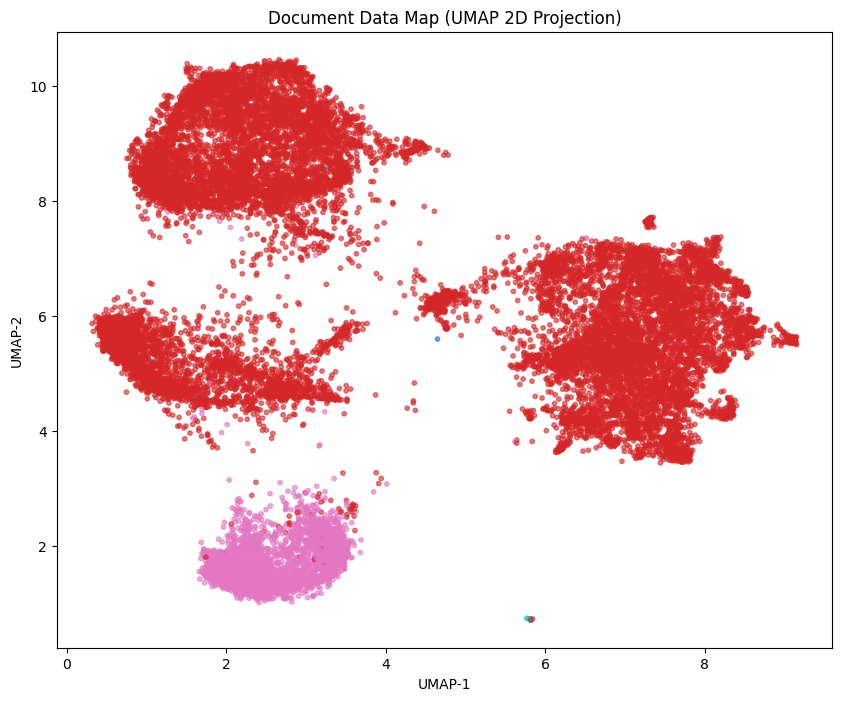

Exception ignored in: <function ResourceTracker.__del__ at 0x1054c1c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104979c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10376dc60>
Traceback (most recent call last

In [15]:
import matplotlib.pyplot as plt

print("Generate datamap manually...")

# 2D reduction
umap_model_2d = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=RANDOM_STATE
)
reduced_embeddings_2d = umap_model_2d.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_embeddings_2d[:, 0],
    reduced_embeddings_2d[:, 1],
    c=topics,
    cmap="tab10",
    s=10,
    alpha=0.6
)
plt.title("Document Data Map (UMAP 2D Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Save
plt.savefig(f"{OUTPUT_DIR}/viz_document_datamap.png", dpi=300, bbox_inches='tight')
print(f"✅ Data map saved as '{OUTPUT_DIR}/viz_document_datamap.png'")
plt.show()
